Final ARIMA model for Amgen Inc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import MinMaxScaler

Importing the dataset

In [2]:
df = pd.read_csv("AMGN_NN_60sec_ret.csv", low_memory=False, delimiter=",")

In [3]:
df["datetime"] = df["TDay"] + " " + df["IntraT"]
df.set_index(pd.DatetimeIndex(df['datetime']), inplace=True)

df.head()

,TDay,IntraT,MidQ,Spread_Q,lag.MidQ,ret.MidQ,lag.Spread_Q,ret.Spread_Q,datetime
datetime,,,,,,,,,
2017-01-03 09:33:00,2017-01-03,09:33:00,147.250,294.50,147.25,0.000000,294.50,0.000000,2017-01-03 09:33:00
2017-01-03 09:34:00,2017-01-03,09:34:00,147.450,294.90,147.25,0.001357,294.50,0.001357,2017-01-03 09:34:00
2017-01-03 09:35:00,2017-01-03,09:35:00,147.320,294.64,147.45,-0.000882,294.90,-0.000882,2017-01-03 09:35:00
2017-01-03 09:36:00,2017-01-03,09:36:00,147.760,295.52,147.32,0.002982,294.64,0.002982,2017-01-03 09:36:00
2017-01-03 09:37:00,2017-01-03,09:37:00,147.805,295.61,147.76,0.000305,295.52,0.000305,2017-01-03 09:37:00


Creating a time series showing the daily mean returns

In [4]:
df_avgm = df.groupby(df.index.date)['ret.MidQ'].mean().reset_index()
df_avgm.columns = ['datetime', 'ret.MidQm']
df_avgm.set_index(pd.DatetimeIndex(df_avgm['datetime']), inplace=True)
df_avgm = df_avgm.drop(columns = {'datetime'})

df_avgm.head()

,ret.MidQm
datetime,
2017-01-03,0.000067
2017-01-04,0.000021
2017-01-05,0.000008
2017-01-06,-0.000057
2017-01-09,-0.000009


Scaling the values

In [5]:
sc = MinMaxScaler(feature_range=(0,1))
df_avgm['ret.MidQmsc'] = sc.fit_transform(df_avgm['ret.MidQm'].values.reshape(-1,1))

df_avgm.head()

,ret.MidQm,ret.MidQmsc
datetime,,
2017-01-03,0.000067,0.699704
2017-01-04,0.000021,0.577794
2017-01-05,0.000008,0.543952
2017-01-06,-0.000057,0.369091
2017-01-09,-0.000009,0.496850


Creating the input for the different models

In [6]:
data_train = df_avgm.iloc[1:101, 1:2].values
data_full = df_avgm.iloc[1:124, 1:2].values
data_test = df_avgm.iloc[101:124, 1:2].values

squared_data_train = [x**2 for x in data_train]
squared_data_train = np.array(squared_data_train)

squared_data_full = [x**2 for x in data_full]
squared_data_full = np.array(squared_data_full)

In [7]:
data_train3d = df_avgm.iloc[3:103, 1:2].values
data_test3d = df_avgm.iloc[103:124, 1:2].values

Plots of ACF and PACF

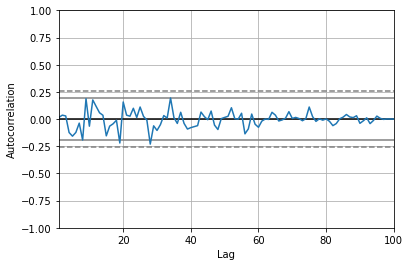

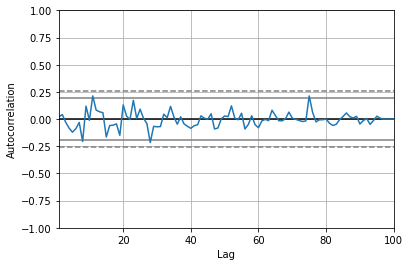

In [8]:
autocorrelation_plot(data_train)
plt.show()

autocorrelation_plot(squared_data_train)
plt.show()

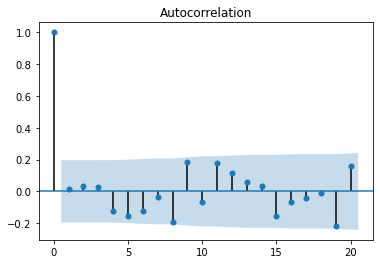

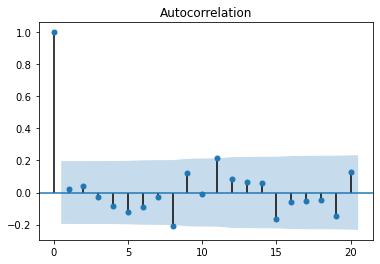

In [9]:
plot_acf(data_train)
plt.show()

plot_acf(squared_data_train)
plt.show()

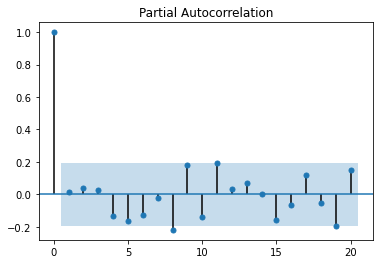

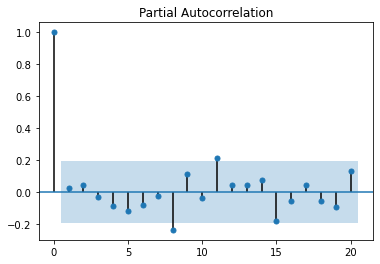

In [10]:
plot_pacf(data_train)
plt.show()

plot_pacf(squared_data_train)
plt.show()

Introduction of the ARIMA1 model

In [11]:
model = ARIMA(data_train, order=(8,1,8))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(8, 1, 8)   Log Likelihood                  80.623
Date:                Sun, 23 Jan 2022   AIC                           -127.246
Time:                        22:43:49   BIC                            -83.129
Sample:                             0   HQIC                          -109.396
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7144      0.229     -3.117      0.002      -1.164      -0.265
ar.L2         -0.5482      0.290     -1.890      0.059      -1.116       0.020
ar.L3         -0.1806      0.266     -0.680      0.4

C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


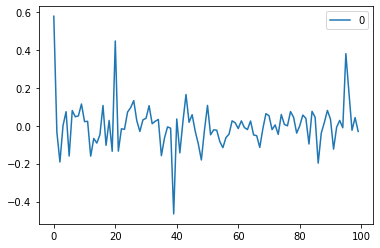

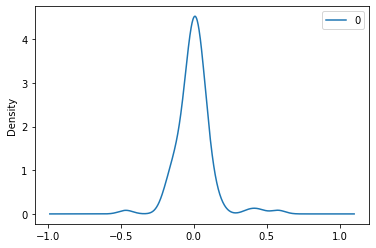

                0
count  100.000000
mean     0.002456
std      0.121808
min     -0.465346
25%     -0.046127
50%      0.000388
75%      0.044631
max      0.577794


In [12]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

Making a forecast using the ARIMA1 model

In [13]:
output1 = model_fit.forecast(steps=20)
output1 = pd.DataFrame({'predictionssc': output1[:]})

Visualization of the results

In [14]:
data_test = data_test[0:20]
data_test = pd.DataFrame({'realsc': data_test[:, 0]})

In [15]:
output1['predictions'] = sc.inverse_transform(output1['predictionssc'].values.reshape(-1,1))
data_test['real'] = sc.inverse_transform(data_test['realsc'].values.reshape(-1,1))

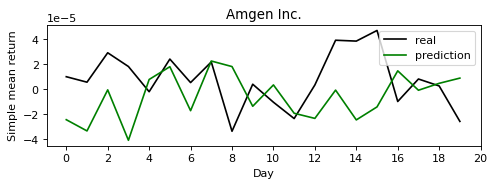

In [16]:
plt.figure(figsize=(7, 2), dpi=80)
plt.plot(data_test['real'], color='black', label='real')
plt.plot(output1['predictions'], color='green', label='prediction')
plt.xticks(np.arange(0, 20+1, 2.0))
plt.title('Amgen Inc.')
plt.xlabel('Day')
plt.ylabel('Simple mean return')
plt.legend()
plt.show()

Mean squared error of the results

In [17]:
data_test_mse = data_test.iloc[:, 0:1].values
output11 = output1.iloc[:, 0:1].values

diff_res = np.subtract(data_test_mse, output11)
sq_res = np.square(diff_res)
mse_res = sq_res.mean()

print(mse_res)

0.008219632402869827


In [18]:
print(data_test)

      realsc      real
0   0.548499  0.000010
1   0.536742  0.000006
2   0.599902  0.000029
3   0.570401  0.000018
4   0.516246 -0.000002
5   0.586375  0.000024
6   0.535891  0.000005
7   0.580186  0.000022
8   0.431340 -0.000033
9   0.532355  0.000004
10  0.493705 -0.000010
11  0.458640 -0.000023
12  0.530763  0.000004
13  0.626834  0.000039
14  0.624975  0.000039
15  0.647796  0.000047
16  0.495288 -0.000010
17  0.543566  0.000008
18  0.528663  0.000003
19  0.452511 -0.000026


In [19]:
print(output1)

    predictionssc   predictions
0        0.456189 -2.420274e-05
1        0.432062 -3.319077e-05
2        0.520239 -3.416004e-07
3        0.411968 -4.067663e-05
4        0.542541  7.966973e-06
5        0.569979  1.818843e-05
6        0.475553 -1.698891e-05
7        0.582187  2.273650e-05
8        0.570271  1.829725e-05
9        0.485027 -1.345924e-05
10       0.530863  3.616291e-06
11       0.470001 -1.905725e-05
12       0.458980 -2.316290e-05
13       0.519706 -5.399942e-07
14       0.455725 -2.437551e-05
15       0.483647 -1.397328e-05
16       0.561094  1.487839e-05
17       0.519450 -6.353780e-07
18       0.534297  4.895503e-06
19       0.545501  9.069606e-06


Introducing the ARIMA2 model and making forecasts

C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


predicted=0.456189, expected=0.548499


C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


predicted=0.526468, expected=0.536742


C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


predicted=0.508983, expected=0.599902


C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


predicted=0.416939, expected=0.570401


C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


predicted=0.576752, expected=0.516246


C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


predicted=0.549104, expected=0.586375


C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


predicted=0.474990, expected=0.535891


C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


predicted=0.549863, expected=0.580186


C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


predicted=0.533110, expected=0.431340


C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


predicted=0.544514, expected=0.532355


C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


predicted=0.554746, expected=0.493705


C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


predicted=0.454621, expected=0.458640


C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


predicted=0.515250, expected=0.530763


C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


predicted=0.519881, expected=0.626834


C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


predicted=0.491706, expected=0.624975


C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


predicted=0.529957, expected=0.647796


C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


predicted=0.587782, expected=0.495288


C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


predicted=0.486542, expected=0.543566


C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


predicted=0.566221, expected=0.528663


C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


predicted=0.484766, expected=0.452511


C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


predicted=0.499407, expected=0.469261


C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


predicted=0.500204, expected=0.442868
predicted=0.497343, expected=0.274725
Test MSE: 0.0080161842


C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


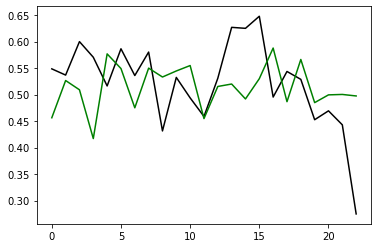

In [20]:
X = data_full
size = int(len(X) * 0.82)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(8,1,8))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
diff_res = np.subtract(test, predictions)
sq_res = np.square(diff_res)
mse_res = sq_res.mean()
print('Test MSE: %.10f' % mse_res)
# plot forecasts against actual outcomes
plt.plot(test, color='black')
plt.plot(predictions, color='green')
plt.show()

Shaping the predictions

In [21]:
predictions = predictions[0:20]
output2 = pd.DataFrame({'predictionssc': predictions[:]})
output2['predictions'] = sc.inverse_transform(output2['predictionssc'].values.reshape(-1,1))

Visualization of the results

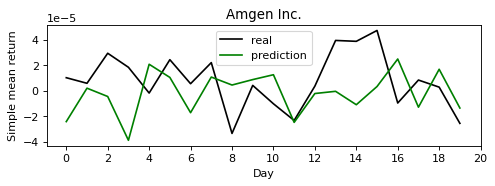

In [22]:
plt.figure(figsize=(7, 2), dpi=80)
plt.plot(data_test['real'], color='black', label='real')
plt.plot(output2['predictions'], color='green', label='prediction')
plt.xticks(np.arange(0, 20+1, 2.0))
plt.title('Amgen Inc.')
plt.xlabel('Day')
plt.ylabel('Simple mean return')
plt.legend()
plt.show()

Mean squared error of the results

In [23]:
output22 = output2.iloc[:, 0:1].values

diff_res = np.subtract(data_test_mse, output22)
sq_res = np.square(diff_res)
mse_res = sq_res.mean()

print(mse_res)

0.006097663448479819


In [24]:
print(output2)

    predictionssc   predictions
0        0.456189 -2.420274e-05
1        0.526468  1.979228e-06
2        0.508983 -4.534901e-06
3        0.416939 -3.882489e-05
4        0.576752  2.071186e-05
5        0.549104  1.041178e-05
6        0.474990 -1.719861e-05
7        0.549863  1.069448e-05
8        0.533110  4.453264e-06
9        0.544514  8.701925e-06
10       0.554746  1.251385e-05
11       0.454621 -2.478685e-05
12       0.515250 -2.200057e-06
13       0.519881 -4.749381e-07
14       0.491706 -1.097109e-05
15       0.529957  3.278948e-06
16       0.587782  2.482084e-05
17       0.486542 -1.289480e-05
18       0.566221  1.678874e-05
19       0.484766 -1.355642e-05


In [25]:
print(data_test)

      realsc      real
0   0.548499  0.000010
1   0.536742  0.000006
2   0.599902  0.000029
3   0.570401  0.000018
4   0.516246 -0.000002
5   0.586375  0.000024
6   0.535891  0.000005
7   0.580186  0.000022
8   0.431340 -0.000033
9   0.532355  0.000004
10  0.493705 -0.000010
11  0.458640 -0.000023
12  0.530763  0.000004
13  0.626834  0.000039
14  0.624975  0.000039
15  0.647796  0.000047
16  0.495288 -0.000010
17  0.543566  0.000008
18  0.528663  0.000003
19  0.452511 -0.000026


Introduction of the ARIMA3 model

In [26]:
model3d = ARIMA(data_train3d, order=(8,1,8))
model_fit = model3d.fit()
# summary of fit model
print(model_fit.summary())

C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(8, 1, 8)   Log Likelihood                  79.171
Date:                Sun, 23 Jan 2022   AIC                           -124.342
Time:                        22:44:21   BIC                            -80.225
Sample:                             0   HQIC                          -106.493
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0572      0.231     -4.584      0.000      -1.509      -0.605
ar.L2         -0.5068      0.474     -1.070      0.285      -1.435       0.422
ar.L3          0.0448      0.402      0.111      0.9

C:\Users\nmart\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


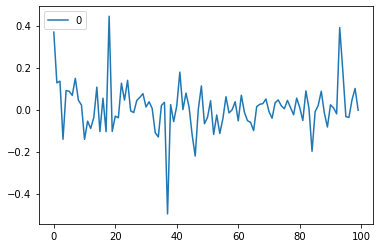

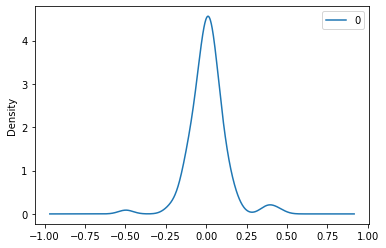

                0
count  100.000000
mean     0.010005
std      0.114722
min     -0.496725
25%     -0.039284
50%      0.009804
75%      0.051581
max      0.444775


In [27]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

Making a forecast using the ARIMA3 model

In [28]:
output3 = model_fit.forecast(steps=20)
output3 = pd.DataFrame({'predictionssc': output3[:]})

Visualization of the results

In [29]:
data_test3d = data_test3d[0:20]
data_test3d = pd.DataFrame({'realsc': data_test3d[:, 0]})

In [30]:
output3['predictions'] = sc.inverse_transform(output3['predictionssc'].values.reshape(-1,1))
data_test3d['real'] = sc.inverse_transform(data_test3d['realsc'].values.reshape(-1,1))

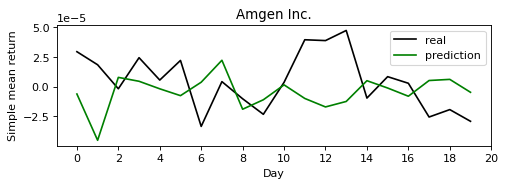

In [31]:
plt.figure(figsize=(7, 2), dpi=80)
plt.plot(data_test3d['real'], color='black', label='real')
plt.plot(output3['predictions'], color='green', label='prediction')
plt.xticks(np.arange(0, 20+1, 2.0))
plt.title('Amgen Inc.')
plt.xlabel('Day')
plt.ylabel('Simple mean return')
plt.legend()
plt.show()

Mean squared error of the results

In [32]:
data_test_mse3d = data_test3d.iloc[:, 0:1].values
output33 = output3.iloc[:, 0:1].values

diff_res = np.subtract(data_test_mse3d, output33)
sq_res = np.square(diff_res)
mse_res = sq_res.mean()

print(mse_res)

0.007331782499382976


In [33]:
print(output3)

    predictionssc  predictions
0        0.504450    -0.000006
1        0.400013    -0.000045
2        0.541947     0.000008
3        0.533155     0.000004
4        0.516170    -0.000002
5        0.500724    -0.000008
6        0.531048     0.000004
7        0.580566     0.000022
8        0.470104    -0.000019
9        0.491451    -0.000011
10       0.525031     0.000001
11       0.494414    -0.000010
12       0.475269    -0.000017
13       0.487631    -0.000012
14       0.534467     0.000005
15       0.517941    -0.000001
16       0.499426    -0.000008
17       0.534881     0.000005
18       0.537447     0.000006
19       0.508321    -0.000005


In [34]:
print(data_test3d)

      realsc      real
0   0.599902  0.000029
1   0.570401  0.000018
2   0.516246 -0.000002
3   0.586375  0.000024
4   0.535891  0.000005
5   0.580186  0.000022
6   0.431340 -0.000033
7   0.532355  0.000004
8   0.493705 -0.000010
9   0.458640 -0.000023
10  0.530763  0.000004
11  0.626834  0.000039
12  0.624975  0.000039
13  0.647796  0.000047
14  0.495288 -0.000010
15  0.543566  0.000008
16  0.528663  0.000003
17  0.452511 -0.000026
18  0.469261 -0.000019
19  0.442868 -0.000029
